# Xgboost-主要参数

###1.常规参数
booster：
  
  gbtree 树模型作为基分类器（默认）
  
  gbliner 线性模型作为基分类器
silent：
  
  silent = 0:时，不输出中间过程（默认）
  
  silent = 1：时，输出中间过程
nthread：
  
  nthread = -1时，使用全部CPU进行并行运算（默认）
  
  nthread = 1时，使用1个CPU进行运算

###2.模型参数
  n_estimatores：
  
  含义：总共迭代次数，即决策树的个数
  
  early_stopping_rounds：

含义：在验证集上，当连续迭代n次，分数没有提高后，提前终止训练

调参：防止过度拟合

max_depth:

含义：树的深度，默认值为6典型值为3~10.

调参：值越大，越容易过拟合；值越小，越容易欠拟合。

min_child_weight：

含义：默认值为1

调参：值越大，越容易欠拟合；值越小，越容易过度拟合（值较大时，避免模型学习到局部的特殊样本）

subsample：

含义：训练每棵树时，使用的数据占全部训练集的比列，默认为1，典型值为0.5~1

调参：防止过拟合

colsample_bytree：

含义：训练每棵树时，使用的特征占全部特征的比列。默认值为1，典型值为0.5~1

调参：防止过度拟合

scale_pos_weight：

含义：正样本权重，在二分类任务中，当正样本比例失衡时，设置正样本的权重，模型效果更好。例如，当正负样本比例为1:10时，scale_pos_weight=10



###3.学习任务参数
###learning_rate：

含义：学习率，控制每次迭代的步长，默认0.3

调参：值越小，训练越慢。

典型值：0.01-0.2

###objective 目标函数

回归任务

reg：linear 默认

reg：logisitic

二分类

binary：logistics 概率

binary：logitraw 类别

多分类

multi：softmax num_class = n 返回类别

multi：softprob num_class = n 返回概率

rank：pairwise

###eval_metric
回归任务（默认rmse）

rmse----均方根误差

mae----平均绝对误差

分类任务（默认error）

auc----roc曲线下面积

error----错误率（二分类）

merror----错误率（多分类）

logloss----负对数似然函数（二分类）

mlogloss----负对数似然函数（多分类）

###gamma

惩罚项系数，指定节点分裂所需的最小损失函数下降值

###alpha
L1正则化系数，默认为1
###lambda
L2正则化系数，默认为1

# xgboost-sklearn 实例

In [75]:
import xgboost as xgb
import pandas as pd
import numpy as np
from xgboost.sklearn import XGBClassifier,XGBRegressor
from sklearn import metrics
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score
from xgboost import plot_importance
import matplotlib.pyplot as plt

In [2]:
def loadData(path,seed,test_size):

  pima = pd.read_csv(path)
  trains = pima.iloc[:,0:8]
  labels = pima.iloc[:,8]
  train_data,test_data,train_label,test_label = train_test_split(trains,labels,test_size=test_size,random_state=seed)
  print('训练样本数量：',len(train_label),'\n测试样本数量：',len(test_label))
  return train_data,test_data,train_label,test_label


In [3]:
# path = '/content/sample_data/diabetes.csv'
path = '/content/drive/MyDrive/xgboost/diabetes.csv'

In [4]:
train_data,test_data,train_label,test_label = loadData(path,seed = 7,test_size = 0.3)

训练样本数量： 537 
测试样本数量： 231


In [ ]:
train_data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age
590,11,111,84,40,0,46.8,0.925,45
692,2,121,70,32,95,39.1,0.886,23
492,4,99,68,38,0,32.8,0.145,33
205,5,111,72,28,0,23.9,0.407,27
709,2,93,64,32,160,38.0,0.674,23


####特征含义
pregnancies：怀孕次数

Clucose：葡萄糖

BloodPressure：血压（mmHg）

SkinThickness：皮层厚度（mm）

Insulin：胰岛素2小时血清胰岛素（mmU/ML）

BMI：体重指数

DiabetesPedigreeFunction：糖尿病谱系功能



---



In [5]:
def xgboost_train(train_data,test_data,train_label,test_label):
  model = xgb.XGBClassifier(
      max_depth = 3,
      min_child_weight = 1, #最小叶子节点权重和，值过高欠拟合；如果在一次分裂中，叶子节点上所有样本的权重和小于min_child_weight則停止分裂，能够有效的防止过拟合
      learning_rate = 0.1,
      n_estimators = 500, #迭代次数
      silent = 1,
      objective = 'binary:logistic', #二分类的逻辑回归
      gamma = 0, 
      max_delta_step = 0,
      subsamples = 0.8,
      colsamples_bytree = 0.8,
      reg_alpha = 0,
      reg_lambda = 0,
      scale_pos_weight = 1,
      seed = 1,
  )

  model.fit(train_data, train_label, eval_metric = 'auc', verbose = True, eval_set = [(test_data,test_label)],
            early_stopping_rounds = 100) #eval_set:进行测试的数据集
  
  y_pre = model.predict(test_data)
  y_pro = model.predict_proba(test_data)[:,1]

  print('AUC: %f'%metrics.roc_auc_score(test_label,y_pro))

  print('ACC: %f'%metrics.accuracy_score(test_label,y_pre))

  return model


In [6]:
if __name__=='__main__':
  model = xgboost_train(train_data,test_data,train_label,test_label)

[0]	validation_0-auc:0.812277
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.821914
[2]	validation_0-auc:0.8322
[3]	validation_0-auc:0.822076
[4]	validation_0-auc:0.829729
[5]	validation_0-auc:0.829608
[6]	validation_0-auc:0.832847
[7]	validation_0-auc:0.836006
[8]	validation_0-auc:0.830701
[9]	validation_0-auc:0.828879
[10]	validation_0-auc:0.830053
[11]	validation_0-auc:0.829649
[12]	validation_0-auc:0.826328
[13]	validation_0-auc:0.829406
[14]	validation_0-auc:0.827867
[15]	validation_0-auc:0.829446
[16]	validation_0-auc:0.830418
[17]	validation_0-auc:0.831633
[18]	validation_0-auc:0.833617
[19]	validation_0-auc:0.834467
[20]	validation_0-auc:0.833171
[21]	validation_0-auc:0.834913
[22]	validation_0-auc:0.83556
[23]	validation_0-auc:0.834629
[24]	validation_0-auc:0.834427
[25]	validation_0-auc:0.833738
[26]	validation_0-auc:0.834629
[27]	validation_0-auc:0.834224
[28]	validation_0-auc:0.83637
[29]	validation_0-auc:0.837221
[30]	validation_0-a

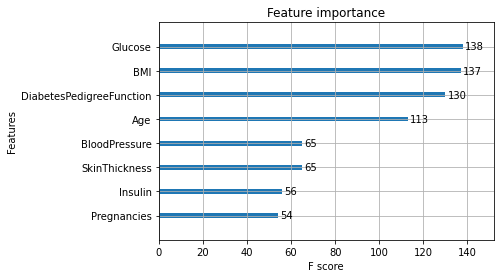

In [10]:
plot_importance(model)
pyplot.show() #可视化特征排名

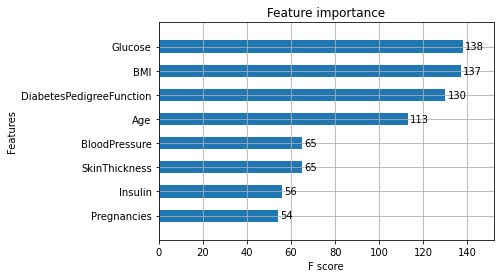

array([0.09760594, 0.26863706, 0.07325009, 0.09343641, 0.08621568,
       0.15744868, 0.09840079, 0.1250053 ], dtype=float32)

In [17]:
 
xgb.plot_importance(model,height=0.5)
plt.show()
importance = model.feature_importances_
importance

#网络搜索调参
调用GridSearchCV方法
###1.最佳迭代次数





In [ ]:
def n_estimators():
  param_test = {
      'n_estimators':[5,10,20,30,400,500,700]
  }
  model = xgb.XGBClassifier(
      max_depth = 3,
      min_child_weight = 1, #最小叶子节点权重和，值过高欠拟合；如果在一次分裂中，叶子节点上所有样本的权重和小于min_child_weight則停止分裂，能够有效的防止过拟合
      learning_rate = 0.1,
      # n_estimators = 500, #迭代次数
      silent = 1,
      objective = 'binary:logistic', #二分类的逻辑回归
      gamma = 0, 
      max_delta_step = 0,
      subsamples = 0.8,
      colsamples_bytree = 0.8,
      reg_alpha = 0,
      reg_lambda = 0,
      scale_pos_weight = 1,
      seed = 1,
  )

  gsearch = GridSearchCV(estimator=model, param_grid=param_test, scoring='f1', cv=5)
  gsearch.fit(train_data,train_label)
  print('每轮迭代运行结果：\n', gsearch.cv_results_, '\n模型最佳取值:\n', gsearch.best_params_, '\n最佳模型得分:\n', gsearch.best_score_)

  return gsearch.best_params_

In [ ]:
if __name__ == '__main__':
  n_estimators = n_estimators()

每轮迭代运行结果：
 {'mean_fit_time': array([0.0231956 , 0.01297598, 0.01244135, 0.01729145, 0.13087254,
       0.16232786, 0.21339269]), 'std_fit_time': array([0.00376918, 0.00576623, 0.00029794, 0.00315546, 0.00455445,
       0.00982151, 0.00764929]), 'mean_score_time': array([0.00753875, 0.00210199, 0.00204201, 0.00250516, 0.00435619,
       0.00453224, 0.00544758]), 'std_score_time': array([1.23105099e-03, 2.53914000e-04, 6.31724478e-05, 4.43402579e-04,
       5.52786880e-04, 2.03552205e-04, 9.21456741e-04]), 'param_n_estimators': masked_array(data=[5, 10, 20, 30, 400, 500, 700],
             mask=[False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'n_estimators': 5}, {'n_estimators': 10}, {'n_estimators': 20}, {'n_estimators': 30}, {'n_estimators': 400}, {'n_estimators': 500}, {'n_estimators': 700}], 'split0_test_score': array([0.61538462, 0.63013699, 0.6       , 0.57534247, 0.6       ,
       0.61111111, 0.57534247]), 'split1_te

得到在学习率为0.1时，最佳决策树的数目为30

###2.最佳min_child_weight和max_depth

In [ ]:
def max_depthANDmin_child_weight():
  param_test2 = {
      'max_depth':[1,2,3,4,5],
      'min_child_weight':[0,1,2]
  }
  model = xgb.XGBClassifier(
      # max_depth = 3,
      # min_child_weight = 1, #最小叶子节点权重和，值过高欠拟合；如果在一次分裂中，叶子节点上所有样本的权重和小于min_child_weight則停止分裂，能够有效的防止过拟合
      learning_rate = 0.1,
      n_estimators = 30, #迭代次数
      silent = 1,
      objective = 'binary:logistic', #二分类的逻辑回归
      gamma = 0, 
      max_delta_step = 0,
      subsamples = 0.8,
      colsamples_bytree = 0.8,
      reg_alpha = 0,
      reg_lambda = 0,
      scale_pos_weight = 1,
      seed = 1,
  )
  gsearch2 = GridSearchCV(estimator=model, param_grid=param_test2, scoring='f1', cv=5)
  gsearch2.fit(train_data,train_label)
  print('每轮迭代运行结果：\n', gsearch2.cv_results_, '\n模型最佳取值:\n', gsearch2.best_params_, '\n最佳模型得分:\n', gsearch2.best_score_)

  return gsearch2.best_params_

In [ ]:
max_depthANDmin_child_weight()

每轮迭代运行结果：
 {'mean_fit_time': array([0.0129003 , 0.0118834 , 0.01144042, 0.01419706, 0.01325336,
       0.01406345, 0.01836219, 0.01557746, 0.01598387, 0.02099032,
       0.01914144, 0.01851759, 0.02361097, 0.02201843, 0.0215569 ]), 'std_fit_time': array([4.09771321e-03, 2.31627808e-03, 1.33278838e-03, 1.50065338e-03,
       2.31383559e-04, 1.14108475e-03, 2.63092947e-03, 3.74434495e-04,
       1.31134697e-03, 3.13900470e-03, 1.22949299e-03, 4.23173799e-04,
       1.74349295e-03, 8.53838149e-05, 5.41368524e-04]), 'mean_score_time': array([0.00241537, 0.00252571, 0.00240884, 0.00258894, 0.00261283,
       0.00269756, 0.00262184, 0.00225043, 0.00224638, 0.0024035 ,
       0.00260262, 0.00229425, 0.0023562 , 0.00242081, 0.00246973]), 'std_score_time': array([1.56906772e-04, 4.15486404e-04, 2.21757815e-04, 8.20763222e-05,
       2.94603603e-04, 2.02937917e-04, 2.73798568e-04, 5.09256727e-05,
       3.06317310e-05, 1.22100763e-04, 6.17754278e-04, 8.07238131e-05,
       9.18543091e-05, 1.0609

{'max_depth': 5, 'min_child_weight': 2}

可以得到最佳max_depth = 5，min_child_weight = 2
###3.最佳gamma

In [ ]:
def gamma():
  param_test3 = {
      'gamma':[0.1,0.2,0.3,0.4,0.5]
  }
  model = xgb.XGBClassifier(
      max_depth = 5,
      min_child_weight = 2, #最小叶子节点权重和，值过高欠拟合；如果在一次分裂中，叶子节点上所有样本的权重和小于min_child_weight則停止分裂，能够有效的防止过拟合
      learning_rate = 0.1,
      n_estimators = 30, #迭代次数
      silent = 1,
      objective = 'binary:logistic', #二分类的逻辑回归
      # gamma = 0, 
      max_delta_step = 0,
      subsamples = 0.8,
      colsamples_bytree = 0.8,
      reg_alpha = 0,
      reg_lambda = 0,
      scale_pos_weight = 1,
      seed = 1,
  )
  gsearch3 = GridSearchCV(estimator=model, param_grid=param_test3, scoring='f1', cv=5)
  gsearch3.fit(train_data,train_label)
  print('每轮迭代运行结果：\n', gsearch3.cv_results_, '\n模型最佳取值:\n', gsearch3.best_params_, '\n最佳模型得分:\n', gsearch3.best_score_)

  return gsearch3.best_params_

In [ ]:
gamma()

每轮迭代运行结果：
 {'mean_fit_time': array([0.02732277, 0.02519932, 0.02749333, 0.02759552, 0.02638321]), 'std_fit_time': array([0.00157426, 0.00100636, 0.0024925 , 0.00189878, 0.00156681]), 'mean_score_time': array([0.00322952, 0.00302382, 0.00292959, 0.00290718, 0.00392895]), 'std_score_time': array([0.00036756, 0.00032663, 0.00015829, 0.00015425, 0.00137552]), 'param_gamma': masked_array(data=[0.1, 0.2, 0.3, 0.4, 0.5],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'gamma': 0.1}, {'gamma': 0.2}, {'gamma': 0.3}, {'gamma': 0.4}, {'gamma': 0.5}], 'split0_test_score': array([0.64864865, 0.63888889, 0.62857143, 0.64788732, 0.61111111]), 'split1_test_score': array([0.7027027 , 0.65714286, 0.65753425, 0.65753425, 0.65753425]), 'split2_test_score': array([0.58333333, 0.5915493 , 0.55555556, 0.54794521, 0.54794521]), 'split3_test_score': array([0.76056338, 0.75675676, 0.73684211, 0.71232877, 0.74666667]), 'split4_test_score': arra

{'gamma': 0.1}

最佳gamma为0.1
###4.最佳subsample和colsample_bytree

In [ ]:
def subsampleANDcolsample():
  param_test4 = {
      'subsample':[0.5,0.6,0.7,0.8,0.9],
      'colsample_bytree':[0.5,0.6,0.7,0.8,0.9]
  }
  model = xgb.XGBClassifier(
      max_depth = 5,
      min_child_weight = 2, #最小叶子节点权重和，值过高欠拟合；如果在一次分裂中，叶子节点上所有样本的权重和小于min_child_weight則停止分裂，能够有效的防止过拟合
      learning_rate = 0.1,
      n_estimators = 30, #迭代次数
      silent = 1,
      objective = 'binary:logistic', #二分类的逻辑回归
      gamma = 0.1, 
      max_delta_step = 0,
      # subsamples = 0.8,
      # colsamples_bytree = 0.8,
      reg_alpha = 0,
      reg_lambda = 0,
      scale_pos_weight = 1,
      seed = 1,
  )
  gsearch4 = GridSearchCV(estimator=model, param_grid=param_test4, scoring='f1', cv=5)
  gsearch4.fit(train_data,train_label)
  print('每轮迭代运行结果：\n', gsearch4.cv_results_, '\n模型最佳取值:\n', gsearch4.best_params_, '\n最佳模型得分:\n', gsearch4.best_score_)

  return gsearch4.best_params_

In [ ]:
subsampleANDcolsample()

每轮迭代运行结果：
 {'mean_fit_time': array([0.02041664, 0.02090087, 0.02200451, 0.02043886, 0.02025418,
       0.01870732, 0.02115245, 0.02097511, 0.01816225, 0.01862421,
       0.01945138, 0.01864915, 0.02106552, 0.02167525, 0.02064986,
       0.02108994, 0.022087  , 0.02091694, 0.02012691, 0.02131815,
       0.02158051, 0.02136707, 0.02118411, 0.02209229, 0.02215152]), 'std_fit_time': array([0.0028994 , 0.0012485 , 0.00148419, 0.0014988 , 0.00221432,
       0.00060851, 0.00261635, 0.0033644 , 0.00104499, 0.00163382,
       0.0009823 , 0.00038457, 0.00205404, 0.00084819, 0.00106662,
       0.00140577, 0.00182014, 0.00064766, 0.00052095, 0.0015178 ,
       0.00173298, 0.0007438 , 0.00125052, 0.00127104, 0.00131379]), 'mean_score_time': array([0.00283647, 0.00318522, 0.00269513, 0.00264034, 0.00270162,
       0.00269551, 0.00296183, 0.00272226, 0.00242934, 0.00252604,
       0.00286736, 0.00233979, 0.00278196, 0.00295558, 0.00346098,
       0.0028223 , 0.00362873, 0.00275946, 0.00261259, 0.0027

{'colsample_bytree': 0.9, 'subsample': 0.5}

得到最佳subsample = 0.5，colsample_bytree = 0.9
###5.调参后的模型

In [ ]:
def new_xgboost_train(train_data,test_data,train_label,test_label):
  model1 = xgb.XGBClassifier(
      max_depth = 5,
      min_child_weight = 2, #最小叶子节点权重和，值过高欠拟合；如果在一次分裂中，叶子节点上所有样本的权重和小于min_child_weight則停止分裂，能够有效的防止过拟合
      learning_rate = 0.1,
      n_estimators = 30, #迭代次数
      silent = 1,
      objective = 'binary:logistic', #二分类的逻辑回归
      gamma = 0.1, 
      max_delta_step = 0,
      subsamples = 0.5,
      colsamples_bytree = 0.9,
      reg_alpha = 0,
      reg_lambda = 0,
      scale_pos_weight = 1,
      seed = 1,
  )

  model1.fit(train_data, train_label, eval_metric = 'auc', verbose = True, eval_set = [(test_data,test_label)],
            early_stopping_rounds = 100) #eval_set:进行测试的数据集
  
  y_pre = model1.predict(test_data)
  y_pro = model1.predict_proba(test_data)[:,1]

  print('AUC: %f'%metrics.roc_auc_score(test_label,y_pro))

  print('ACC: %f'%metrics.accuracy_score(test_label,y_pre))

  return model1


In [ ]:
model1 = new_xgboost_train(train_data, test_data, train_label, test_label)

[0]	validation_0-auc:0.800413
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.804219
[2]	validation_0-auc:0.826936
[3]	validation_0-auc:0.827826
[4]	validation_0-auc:0.825842
[5]	validation_0-auc:0.823089
[6]	validation_0-auc:0.825032
[7]	validation_0-auc:0.826004
[8]	validation_0-auc:0.829163
[9]	validation_0-auc:0.830863
[10]	validation_0-auc:0.831876
[11]	validation_0-auc:0.831511
[12]	validation_0-auc:0.831835
[13]	validation_0-auc:0.833779
[14]	validation_0-auc:0.831592
[15]	validation_0-auc:0.836208
[16]	validation_0-auc:0.837099
[17]	validation_0-auc:0.838638
[18]	validation_0-auc:0.837099
[19]	validation_0-auc:0.837504
[20]	validation_0-auc:0.838354
[21]	validation_0-auc:0.83884
[22]	validation_0-auc:0.837464
[23]	validation_0-auc:0.835925
[24]	validation_0-auc:0.834305
[25]	validation_0-auc:0.834548
[26]	validation_0-auc:0.835277
[27]	validation_0-auc:0.835196
[28]	validation_0-auc:0.83471
[29]	validation_0-auc:0.833495
AUC: 0.838840
ACC

AUC:0.839124-->0.838840

ACC:0.779221-->0.792208

可见提升并不明显，这是因为没有做特征工程,数据清洗的缘故

###6.改变数据集划分以及随机种子


In [ ]:
train_data,test_data,train_label,test_label = loadData(path,seed = 1,test_size = 0.2)

训练样本数量： 614 
测试样本数量： 154


In [ ]:
new_xgboost_train(train_data,test_data,train_label,test_label)

[0]	validation_0-auc:0.830211
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.826722
[2]	validation_0-auc:0.828834
[3]	validation_0-auc:0.840404
[4]	validation_0-auc:0.847475
[5]	validation_0-auc:0.851882
[6]	validation_0-auc:0.855923
[7]	validation_0-auc:0.860698
[8]	validation_0-auc:0.867218
[9]	validation_0-auc:0.869972
[10]	validation_0-auc:0.868503
[11]	validation_0-auc:0.870156
[12]	validation_0-auc:0.867769
[13]	validation_0-auc:0.865748
[14]	validation_0-auc:0.865748
[15]	validation_0-auc:0.867585
[16]	validation_0-auc:0.863728
[17]	validation_0-auc:0.863545
[18]	validation_0-auc:0.862994
[19]	validation_0-auc:0.863545
[20]	validation_0-auc:0.865014
[21]	validation_0-auc:0.865197
[22]	validation_0-auc:0.861892
[23]	validation_0-auc:0.862259
[24]	validation_0-auc:0.859688
[25]	validation_0-auc:0.857668
[26]	validation_0-auc:0.858402
[27]	validation_0-auc:0.857117
[28]	validation_0-auc:0.854913
[29]	validation_0-auc:0.855647
AUC: 0.870156
A

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, colsamples_bytree=0.9,
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=1,
              subsample=1, subsamples=0.5, verbosity=1)

AUC,ACC有了一些提升

再对数据集的划分进行改动

In [ ]:
train_data,test_data,train_label,test_label = loadData(path,seed = 1,test_size = 0.1)

new_xgboost_train(train_data,test_data,train_label,test_label)

训练样本数量： 691 
测试样本数量： 77
[0]	validation_0-auc:0.858836
Will train until validation_0-auc hasn't improved in 100 rounds.
[1]	validation_0-auc:0.86171
[2]	validation_0-auc:0.87033
[3]	validation_0-auc:0.878951
[4]	validation_0-auc:0.883621
[5]	validation_0-auc:0.875
[6]	validation_0-auc:0.882902
[7]	validation_0-auc:0.87931
[8]	validation_0-auc:0.878592
[9]	validation_0-auc:0.872845
[10]	validation_0-auc:0.872845
[11]	validation_0-auc:0.875359
[12]	validation_0-auc:0.875718
[13]	validation_0-auc:0.878592
[14]	validation_0-auc:0.876437
[15]	validation_0-auc:0.874282
[16]	validation_0-auc:0.876437
[17]	validation_0-auc:0.877155
[18]	validation_0-auc:0.873563
[19]	validation_0-auc:0.873563
[20]	validation_0-auc:0.875
[21]	validation_0-auc:0.873563
[22]	validation_0-auc:0.87069
[23]	validation_0-auc:0.875
[24]	validation_0-auc:0.876437
[25]	validation_0-auc:0.876437
[26]	validation_0-auc:0.876437
[27]	validation_0-auc:0.874282
[28]	validation_0-auc:0.874282
[29]	validation_0-auc:0.877874
AUC:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, colsamples_bytree=0.9,
              gamma=0.1, learning_rate=0.1, max_delta_step=0, max_depth=5,
              min_child_weight=2, missing=None, n_estimators=30, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=1, silent=1,
              subsample=1, subsamples=0.5, verbosity=1)

# 基于特征重要性的特征选择
选用乳腺癌数据

In [54]:
import xgboost as xgb
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets

In [55]:
cancer = datasets.load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = 0.2,random_state = 8)

In [56]:
model = xgb.XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=50,silent=True,objective='binary:logistic',booster="gbtree")
model.fit(X_train,y_train)
y_pred = model.predict(X_test)
auc = roc_auc_score(y_test,y_pred)
print("auc:%.2f"%(auc))

auc:0.95


In [57]:
# 获取特征重要性评分
importance = model.feature_importances_
importance

array([0.00924551, 0.016859  , 0.00261166, 0.01844073, 0.00303571,
       0.00658103, 0.0663527 , 0.2005381 , 0.00396072, 0.00727264,
       0.00998891, 0.00572991, 0.00453828, 0.01439565, 0.00548182,
       0.00427298, 0.00049282, 0.        , 0.01544545, 0.01440675,
       0.01871601, 0.01973592, 0.39805064, 0.06359337, 0.00705748,
       0.        , 0.03244395, 0.04395715, 0.00282926, 0.00396582],
      dtype=float32)

In [58]:
#特征重要性去重
threshold = []
for i in importance:
  if i not in threshold:
    threshold.append(i)
threshold = sorted(threshold) #排序

In [64]:
for thre in threshold:

  selection = SelectFromModel(model,threshold=thre,prefit=True)
  select_X_train = selection.transform(X_train)
  selection_model = xgb.XGBClassifier(max_depth=5,learning_rate=0.1,n_estimators=50,silent=True,objective='binary:logistic',booster="gbtree")
  selection_model.fit(select_X_train,y_train)
  # 评估模型
  select_X_test = selection.transform(X_test)
  y_pred = selection_model.predict(select_X_test)
  auc = roc_auc_score(y_test,y_pred)
  print("阈值: %.4f，特征数量:%d，AUC: %.4f" %(thre,select_X_train.shape[1],auc))

阈值: 0.0000，特征数量:30，AUC: 0.9492
阈值: 0.0005，特征数量:28，AUC: 0.9492
阈值: 0.0026，特征数量:27，AUC: 0.9492
阈值: 0.0028，特征数量:26，AUC: 0.9492
阈值: 0.0030，特征数量:25，AUC: 0.9418
阈值: 0.0040，特征数量:24，AUC: 0.9492
阈值: 0.0040，特征数量:23，AUC: 0.9492
阈值: 0.0043，特征数量:22，AUC: 0.9492
阈值: 0.0045，特征数量:21，AUC: 0.9600
阈值: 0.0055，特征数量:20，AUC: 0.9492
阈值: 0.0057，特征数量:19，AUC: 0.9600
阈值: 0.0066，特征数量:18，AUC: 0.9600
阈值: 0.0071，特征数量:17，AUC: 0.9492
阈值: 0.0073，特征数量:16，AUC: 0.9674
阈值: 0.0092，特征数量:15，AUC: 0.9600
阈值: 0.0100，特征数量:14，AUC: 0.9600
阈值: 0.0144，特征数量:13，AUC: 0.9600
阈值: 0.0144，特征数量:12，AUC: 0.9783
阈值: 0.0154，特征数量:11，AUC: 0.9783
阈值: 0.0169，特征数量:10，AUC: 0.9674
阈值: 0.0184，特征数量:9，AUC: 0.9636
阈值: 0.0187，特征数量:8，AUC: 0.9636
阈值: 0.0197，特征数量:7，AUC: 0.9709
阈值: 0.0324，特征数量:6，AUC: 0.9600
阈值: 0.0440，特征数量:5，AUC: 0.9492
阈值: 0.0636，特征数量:4，AUC: 0.9453
阈值: 0.0664，特征数量:3，AUC: 0.9345
阈值: 0.2005，特征数量:2，AUC: 0.9236
阈值: 0.3981，特征数量:1，AUC: 0.9127


In [65]:
#获取被选中的特征
selection = SelectFromModel(model,threshold=0.0154,prefit=True)
select_X_train = selection.transform(X_train)
selection.get_support() #选择特征的掩码

array([False,  True, False,  True, False, False,  True,  True, False,
       False, False, False, False, False, False, False, False, False,
        True, False,  True,  True,  True,  True, False, False,  True,
        True, False, False])

In [66]:
selection.get_support(True) #选择特征的索引

array([ 1,  3,  6,  7, 18, 20, 21, 22, 23, 26, 27])

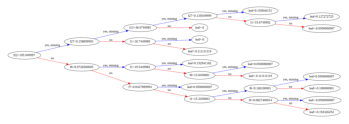

In [74]:
xgb.plot_tree(model,rankdir='LR')
plt.show() #可视化